# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,glob,sys
from tensorflow.keras.backend import clear_session
from tensorflow.keras.applications.vgg16 import VGG16 ,preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# load dataset 

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip

File ‘Food-5K.zip’ already there; not retrieving.



In [14]:
!unzip -qq -o Food-5K.zip

In [15]:
!ls

Food-5K  Food-5K.zip  __MACOSX	sample_data


In [10]:
# !rm -rf validation

In [16]:
!mv Food-5K/* .

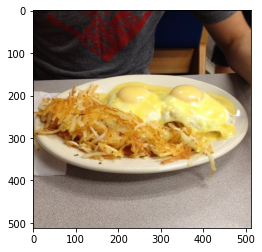

In [17]:
# checking images. # we can see the 1* foood and 0* not food
plt.imshow(image.load_img('training/1_808.jpg'))
plt.show()

In [18]:
# keras style. files are data/train data/test so we should move files
#and inside each tran/test a folder for each class train/food train/notfood.  test/food test/notfood
!mkdir data
# Make directories to store the data Keras-style
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food


# Move the images
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv evaluation/0*.jpg data/train/nonfood
!mv evaluation/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

In [19]:
# set path for image generators
train_path = 'data/train'
valid_path = 'data/test'

# useful for getting number of files

train_images = glob.glob(train_path + '/*/*.jpg')
validation_images = glob.glob(valid_path + '/*/*.jpg')
classes = 2 # for the lzy programmer dataset  incase we downloaded a dataset in keras style we can check number of folders inside train
classes = len(glob.glob(train_path + '/*'))
print(f'number of classes is {classes}')

number of classes is 2


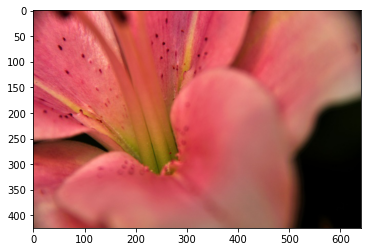

In [27]:
# look at an image for fun
plt.imshow(image.load_img(np.random.choice(train_images)))
plt.show()

In [52]:
# prepare image generators to feed for model
batch_size = 128 # batches to produce in generator
IMAGE_SHAPE = [200,200] # random shape


# create generators
# we are not doing any data augmentation here just preparing in shape needed by vgg16
# train_gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
#   shear_range=0.1, zoom_range=0.2, horizontal_flip=True, preprocessing_function=preprocess_input)
gen = ImageDataGenerator(preprocessing_function=preprocess_input) # when we load images we want to make sure the are shaped like the Vgg

#default label is categorical will be one hot encoded
train_generator = gen.flow_from_directory(train_path, target_size=IMAGE_SHAPE, batch_size=batch_size) 

valid_generator = gen.flow_from_directory(valid_path, target_size=IMAGE_SHAPE, batch_size=batch_size)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# train model using generators with built in pretrained

In [71]:
clear_session() # clear keras backend

# input shape should not be less than 32 when using pretrained Vgg16 and should be of shape (w, h, 3) or (3, w, h)
pretrained = VGG16(input_shape=IMAGE_SHAPE + [3], weights='imagenet',include_top=False) # load pretrain VGG16 model without last 3 dense layers to try transfer
pretrained.trainable = False # we dont want to retrain the loaded layers
x = Flatten()(pretrained.output)
x = Dense(64,'relu')(x)
x = Dense(classes,activation='softmax')(x)
model = Model(inputs=pretrained.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [58]:

# this method take some time 
# /// we can try to create a model that return features (predict only on pretrained body and use output as features for new model)
r = model.fit(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(len(train_images) / batch_size)), validation_steps=int(np.ceil(len(validation_images) / batch_size)),
)

Epoch 1/10
24/24 [==============================] - 31s 1s/step - loss: 5.8595 - accuracy: 0.7860 - val_loss: 0.1741 - val_accuracy: 0.9700
Epoch 2/10
24/24 [==============================] - 30s 1s/step - loss: 0.1377 - accuracy: 0.9641 - val_loss: 0.1294 - val_accuracy: 0.9660
Epoch 3/10
24/24 [==============================] - 30s 1s/step - loss: 0.0531 - accuracy: 0.9717 - val_loss: 0.0939 - val_accuracy: 0.9730
Epoch 4/10
24/24 [==============================] - 30s 1s/step - loss: 0.0164 - accuracy: 0.9880 - val_loss: 0.0622 - val_accuracy: 0.9800
Epoch 5/10
24/24 [==============================] - 30s 1s/step - loss: 0.0072 - accuracy: 0.9937 - val_loss: 0.0881 - val_accuracy: 0.9780
Epoch 6/10
24/24 [==============================] - 30s 1s/step - loss: 0.0031 - accuracy: 0.9972 - val_loss: 0.0752 - val_accuracy: 0.9800
Epoch 7/10
24/24 [==============================] - 30s 1s/step - loss: 0.0030 - accuracy: 0.9963 - val_loss: 0.0710 - val_accuracy: 0.9830
Epoch 8/10
24/24 [==

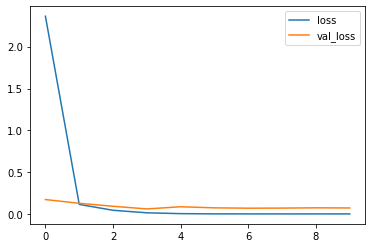

In [59]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

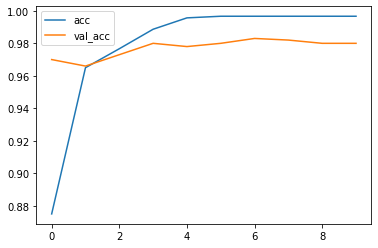

In [60]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

# Train model using pretrained model as feature generator first

In [75]:
# create train/test features 
# first we need input shape to create our data set sizes
pretrained2= VGG16(input_shape=IMAGE_SHAPE + [3], weights='imagenet',include_top=False) # load pretrain VGG16 model without last 3 dense layers to try transfer
pretrained2.trainable = False # we dont want to retrain the loaded layers
out = Flatten()(pretrained2.output)
feature_model = Model(inputs=pretrained2.input, outputs=out)
# we can use this to predict no need for training
random_input = np.random.random([1] + IMAGE_SHAPE + [3]) # return shape (1, w, h, 3)
output = feature_model.predict(random_input)
print(feature_model.summary())
print(f'outputfeature shape {output.shape} we can also see it from model summary')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

# prepare train/valid features

In [139]:
# all data should be of shape N, 18432 
feature_shape = output.shape[1]
n_train =  len(train_images)# number if files in the train path
n_valid =  len(validation_images)# number of files in the valid/test path

# create empty features arrays to populate with the features created from the feature model
x_train = np.zeros((n_train,feature_shape))
y_train = np.zeros((n_train,classes))

x_valid = np.zeros((n_valid,feature_shape))
y_valid = np.zeros((n_valid,classes))



# populate the data
# using image data generator so features are prepared in shape needed by the pretrained model
# since data is not very large we can store them in arrays and use them directly
gen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_gen = gen.flow_from_directory(train_path, target_size=IMAGE_SHAPE, batch_size=batch_size)
valid_gen =  gen.flow_from_directory(valid_path, target_size=IMAGE_SHAPE, batch_size=batch_size)

#loop through generators and pupulate

# === train gen === #
start= 0
for x, y in train_gen:
  # get features
  ft = feature_model.predict(x)
  
  # size of the batch (may not always be batch_size)
  inc = len(y)
  
  # assign to X_train and Ytrain
  x_train[start:start + inc] = ft
  y_train[start:start + inc] = y
  
  # increment i
  start += inc
  print(start)

  if start >= n_train:
    print('breaking now')
    break
print(start)


# === valid gen === #
start= 0
for x, y in valid_gen:
  # get features
  ft = feature_model.predict(x)
  
  # size of the batch (may not always be batch_size)
  inc = len(y)
  
  # assign to X_train and Ytrain
  x_valid[start:start + inc] = ft
  y_valid[start:start + inc] = y
  
  # increment i
  start += inc

  if start >= n_valid:
    print('breaking now')
    break
print(start)



Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
128
256
384
512
640
768
896
1024
1152
1280
1408
1536
1664
1792
1920
2048
2176
2304
2432
2560
2688
2816
2944
3000
breaking now
3000
breaking now
1000


In [140]:
# since features and model are seperated we can normalize the features  before feeding to the prediction model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train2 = scaler.fit_transform(x_train)
x_valid2= scaler.transform(x_valid)

In [141]:
# train the prediction model
i = Input(shape=(feature_shape,))
x = Dense(64,'relu')(i)
x = Dense(classes,activation='softmax')(x)
prediction_model = Model(i,x)
prediction_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(prediction_model.summary())

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 18432)]           0         
_________________________________________________________________
dense_18 (Dense)             (None, 64)                1179712   
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 130       
Total params: 1,179,842
Trainable params: 1,179,842
Non-trainable params: 0
_________________________________________________________________
None


In [142]:

# this method take some time 
# /// we can try to create a model that return features (predict only on pretrained body and use output as features for new model)
r = prediction_model.fit(x_train2, y_train, validation_data=(x_valid2, y_valid),
  epochs=10,
)

Epoch 1/10
94/94 [==============================] - 1s 8ms/step - loss: 0.3338 - accuracy: 0.9133 - val_loss: 0.1960 - val_accuracy: 0.9750
Epoch 2/10
94/94 [==============================] - 0s 5ms/step - loss: 0.0316 - accuracy: 0.9968 - val_loss: 0.2153 - val_accuracy: 0.9750
Epoch 3/10
94/94 [==============================] - 0s 4ms/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.1846 - val_accuracy: 0.9770
Epoch 4/10
94/94 [==============================] - 0s 4ms/step - loss: 8.5776e-04 - accuracy: 0.9990 - val_loss: 0.1847 - val_accuracy: 0.9770
Epoch 5/10
94/94 [==============================] - 0s 5ms/step - loss: 6.6117e-04 - accuracy: 0.9993 - val_loss: 0.1858 - val_accuracy: 0.9780
Epoch 6/10
94/94 [==============================] - 0s 5ms/step - loss: 1.8992e-04 - accuracy: 0.9999 - val_loss: 0.1865 - val_accuracy: 0.9780
Epoch 7/10
94/94 [==============================] - 0s 5ms/step - loss: 9.1635e-05 - accuracy: 1.0000 - val_loss: 0.1875 - val_accuracy: 0.9780
Epoc

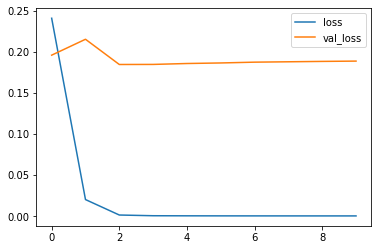

In [150]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

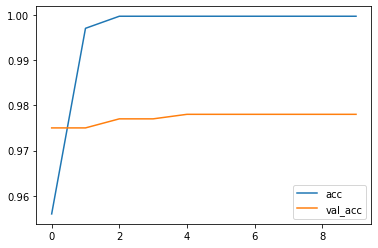

In [151]:
# Plot accuracy per iteration
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

Confusion matrix, without normalization
[[500   0]
 [106 394]]


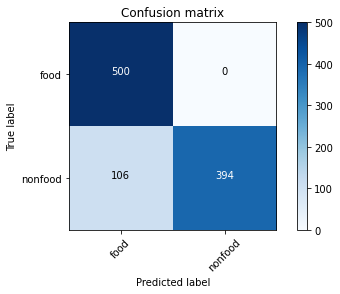

In [147]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
from tensorflow.math import confusion_matrix as cf
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


p_test = prediction_model.predict(x_valid).argmax(axis=1)
y_valid2 = np.argmax(y_valid, axis = 1) # convert one hot encoded labels to integer labels

cm = cf(y_valid2, p_test, num_classes=2, weights=None) 
cm = cm.numpy() # plot cm function need numpy array not tensor
# # cm = confusion_matrix(y_valid, p_test)
plot_confusion_matrix(cm, ['food','nonfood'])

Found 1000 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


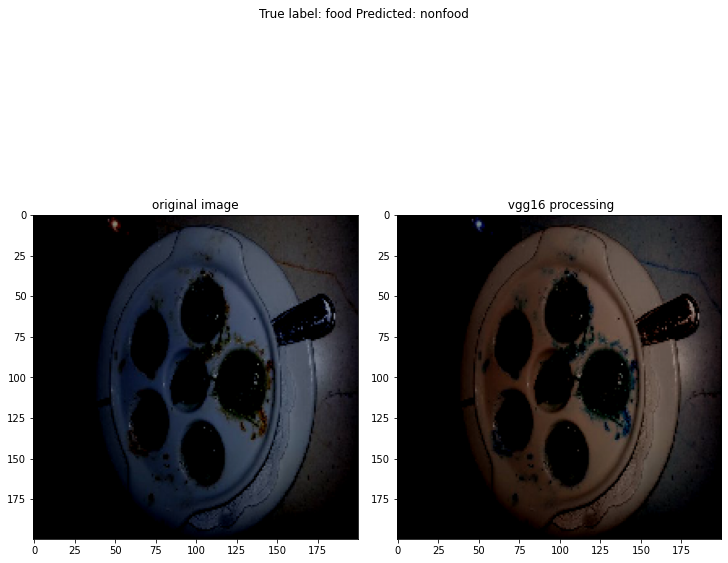

In [212]:
labels = '''food nonfood'''.split()

gen2 = ImageDataGenerator() # take image without processing to see shape of original image 
valid_gen =  gen2.flow_from_directory(valid_path, target_size=IMAGE_SHAPE, batch_size=batch_size)
for x, y in valid_gen:
  # get features
  x2= preprocess_input(x)
  ft = feature_model.predict(x2)
  ft = scaler.transform(ft)
  out =prediction_model.predict(ft).argmax(axis=1)
  lb = np.argmax(y, axis = 1) 
  break
# Show some misclassified examples
misclassified_idx = np.where(out != lb)[0]
i = np.random.choice(misclassified_idx) 
fig, axs = plt.subplots(1, 2, figsize=(10,10),constrained_layout=True)
fig.suptitle("True label: %s Predicted: %s" % (labels[lb[i]], labels[out[i]]))

axs[0].imshow(x[i]/ 255, cmap='gray')
axs[0].set_title('original image');

axs[1].imshow(x2[i]/ 255, cmap='gray')
axs[1].set_title(' vgg16 processing');